# **Name: Anshul Jain**
# **Batch: AIML-A1**
# **PRN: 22070126014**
---

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.utils as vutils
import numpy as np
import os

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#setting manual seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
print(device)

cuda


In [ ]:
#hyperparameters
image_size = 64
batch_size = 32  
latent_dim = 100
lr_D = 0.00005        #discriminator learning rate
lr_G = 0.0002         #generator learning rate
num_epochs = 10
beta1 = 0.5
beta2 = 0.98          

In [ ]:
#loading dataset
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = datasets.ImageFolder(root=r"C:\Users\Anshul\Downloads\archive\img_align_celeba", transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),  #using leakyReLU for improved gradient flow for better stability

            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

generator = Generator(latent_dim).to(device)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            torch.nn.utils.spectral_norm(nn.Conv2d(3, 64, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.4),  

            torch.nn.utils.spectral_norm(nn.Conv2d(64, 128, 4, 2, 1, bias=False)),
            nn.BatchNorm2d(128),  #applying batch normalization
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.4),  

            torch.nn.utils.spectral_norm(nn.Conv2d(128, 256, 4, 2, 1, bias=False)),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.4, inplace=True),

            torch.nn.utils.spectral_norm(nn.Conv2d(256, 512, 4, 2, 1, bias=False)),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.4, inplace=True),

            torch.nn.utils.spectral_norm(nn.Conv2d(512, 1, 4, 1, 0, bias=False)),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

discriminator = Discriminator().to(device)

In [ ]:
criterion = nn.BCELoss() #taking binary cross-entropy loss function

#choosing optimizer adam for both generator and discriminator
optimizer_G = optim.Adam(generator.parameters(), lr=lr_G, betas=(beta1, beta2))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr_D, betas=(beta1, beta2))

In [ ]:
fixed_noise = torch.randn(16, latent_dim, 1, 1, device=device) #using fixed noise for tracking generator's progress

for epoch in range(num_epochs):
    for i, data in enumerate(dataloader):
        real_images = data[0].to(device)
        batch_size = real_images.size(0)

        #label Smoothing: real labels in [0.9, 1.0] and fake labels in [0.1, 0.2]
        real_labels = torch.full((batch_size, 1), np.random.uniform(0.9, 1.0), device=device)
        fake_labels = torch.full((batch_size, 1), np.random.uniform(0.1, 0.2), device=device)

        #training the discriminator
        optimizer_D.zero_grad()
        output_real = discriminator(real_images).view(-1, 1)
        loss_real = criterion(output_real, real_labels)

        noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)
        fake_images = generator(noise)
        output_fake = discriminator(fake_images.detach()).view(-1, 1)
        loss_fake = criterion(output_fake, fake_labels)

        loss_D = loss_real + loss_fake
        loss_D.backward()
        torch.nn.utils.clip_grad_norm_(discriminator.parameters(), 1.0)
        optimizer_D.step()

        #training the generator --- using labels near 1 for generator updates to fool D
        optimizer_G.zero_grad()
        fake_labels_gen = torch.full((batch_size, 1), np.random.uniform(0.9, 1.0), device=device)
        output_fake_G = discriminator(fake_images).view(-1, 1)
        loss_G = criterion(output_fake_G, fake_labels_gen)
        loss_G.backward()
        optimizer_G.step()

        #printing training status periodically(for each epoch and batch-wise)
        if i % 100 == 0:
            print(f"Epoch [{epoch}/{num_epochs}] Batch {i}/{len(dataloader)} Loss D: {loss_D.item()}, Loss G: {loss_G.item()}")
    
    #saving generated images at the end of each epoch
    with torch.no_grad():
        fake_images = generator(fixed_noise)
        grid = vutils.make_grid(fake_images, normalize=True)
        vutils.save_image(grid, f"generated_epoch_{epoch}.png")

print("Training Complete!")

Epoch [0/10] Batch 0/6332 Loss D: 1.4872584342956543, Loss G: 0.8398345708847046
Epoch [0/10] Batch 100/6332 Loss D: 1.2308562994003296, Loss G: 2.345388412475586
Epoch [0/10] Batch 200/6332 Loss D: 1.5521817207336426, Loss G: 1.104672908782959
Epoch [0/10] Batch 300/6332 Loss D: 1.5120967626571655, Loss G: 1.1131575107574463
Epoch [0/10] Batch 400/6332 Loss D: 1.717803955078125, Loss G: 0.6618555784225464
Epoch [0/10] Batch 500/6332 Loss D: 1.3442497253417969, Loss G: 0.7729848623275757
Epoch [0/10] Batch 600/6332 Loss D: 1.4383156299591064, Loss G: 0.8611932992935181
Epoch [0/10] Batch 700/6332 Loss D: 1.455091953277588, Loss G: 0.715423583984375
Epoch [0/10] Batch 800/6332 Loss D: 1.3994742631912231, Loss G: 0.703851580619812
Epoch [0/10] Batch 900/6332 Loss D: 1.417654275894165, Loss G: 0.6905393600463867
Epoch [0/10] Batch 1000/6332 Loss D: 1.3954644203186035, Loss G: 0.7015167474746704
Epoch [0/10] Batch 1100/6332 Loss D: 1.4653263092041016, Loss G: 0.6204371452331543
Epoch [0/10

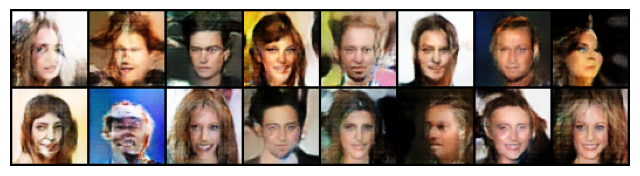

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

#displaying saved image
epoch_num = 3
image_path = f"generated_epoch_{epoch_num}.png"
img = Image.open(image_path)
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.axis("off")
plt.show()